In [1]:
import os
from glob import glob
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
from collections import OrderedDict

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                        ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/', \
                        ref_suffix='', transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.ref_dir = ref_dir
        self.ref_suffix = ref_suffix
        self.target_size = target_size

        if transform is None:
            self.transform = Compose([
                Resize(self.target_size),  # Resize the image to target size
                ToTensor(),  # Convert image to tensor
            ])
        else:
            self.transform = transform

        filenames = [os.path.splitext(file)[0] for file in os.listdir(image_dir)]
        self.ids = {}
        for idx, filename in enumerate(filenames):
            self.ids[idx] = filename

    def __getitem__(self, i):
        basename = self.ids[i]

        ref_file = glob(self.ref_dir + basename + self.ref_suffix + '.*')
        img_file = glob(self.image_dir + basename + '.*')

        ref = cv2.imread(ref_file[0])
        img = cv2.imread(img_file[0])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
        
        # Convert NumPy arrays to PIL Images
        img = Image.fromarray(img)
        ref = Image.fromarray(ref)

        # Apply the transformation
        img = self.transform(img)
        ref = self.transform(ref)

        return img, ref

    def __len__(self):
        return len(self.ids.keys())

def print_sample_image_sizes(dataset, num_samples=10):
    """Print sizes of sample images from the dataset."""
    for i in range(min(num_samples, len(dataset))):
        img, ref = dataset[i]
        # Print transformed sizes; tensors follow (C, H, W) format.
        print(f"Sample {i+1} - Image size: {img.size()}, Reference size: {ref.size()}")

# Assuming the build_dataset function and necessary imports are defined elsewhere
# and the dataset paths are correctly specified:
dataset = CustomDataset()

# Print sizes of 10 sample images
print_sample_image_sizes(dataset, 10)


def __len__(self):
    return len(self.ids.keys())

def build_dataset(image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                    ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/', \
                    test_split=0.15):

    dataset = CustomDataset(image_dir, ref_dir)

    tsplit = test_split
    tsize = int(len(dataset)*tsplit)
    indices = torch.randperm(len(dataset)).tolist()

    train = Subset(dataset, indices[:-tsize])
    test = Subset(dataset, indices[-tsize:])

    train_loader = DataLoader(
      train,
      batch_size=1,
      shuffle=True,
      num_workers=0
    )

    test_loader = DataLoader(
        test,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    return train_loader, test_loader

Sample 1 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 2 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 3 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 4 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 5 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 6 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 7 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 8 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 9 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 10 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])


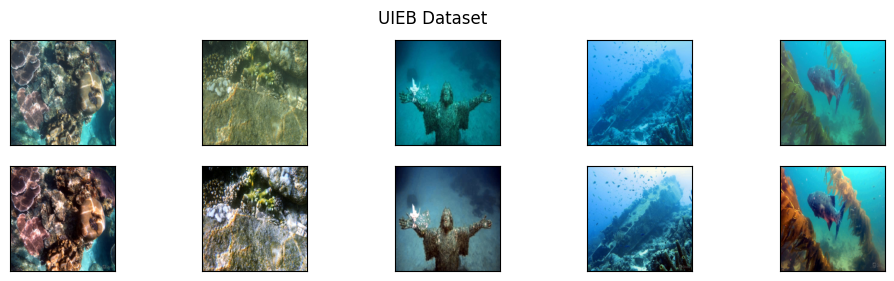

In [5]:
viz_dataset = CustomDataset(image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                    ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/')

common_size = (720, 1280, 3)
target_width = 1280
target_height = 720
num_images = 5

fig, axes = plt.subplots(2, num_images)
fig.set_figwidth(12)
fig.set_figheight(3)
plt.suptitle('UIEB Dataset')
for idx in range(num_images):
    img, ref = viz_dataset[idx]

    # Pad the image with zeros to make it the target size
    axes[0][idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[1][idx].imshow(np.transpose(ref.numpy(), (1, 2, 0)))
#     axes[0][idx].imshow(img)
#     axes[1][idx].imshow(ref)
    axes[0][idx].set_xticks([])
    axes[0][idx].set_yticks([])
    axes[1][idx].set_xticks([])
    axes[1][idx].set_yticks([])

In [6]:
def white_balance(image, lambda_value=0.2):

    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    image = image.astype(np.float32)

    scene_mean = np.mean(image)

    # Calculate lighting estimate
    lighting_estimate = 0.5 + lambda_value * scene_mean

    # Adjust the image by the lighting estimate
    balanced_image = image * (lighting_estimate / scene_mean)

    balanced_image = np.clip(balanced_image, 0.0, 1.0)

    return torch.tensor(np.transpose(balanced_image, (2,0,1)))

def clahe(img, clip_limit=2.0, grid_size=(8, 8)):

    img = np.transpose(img.numpy(), (1, 2, 0))
        
    img = cv2.convertScaleAbs(img, alpha=(65535.0/255.0))

    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    cl_l_channel = clahe.apply(l_channel)

    clahe_img = cv2.merge((cl_l_channel, a_channel, b_channel))

    clahe_img_bgr = cv2.cvtColor(clahe_img, cv2.COLOR_LAB2RGB)

    return torch.tensor(np.transpose(clahe_img_bgr, (2,0,1)).astype(np.float32) / 255)

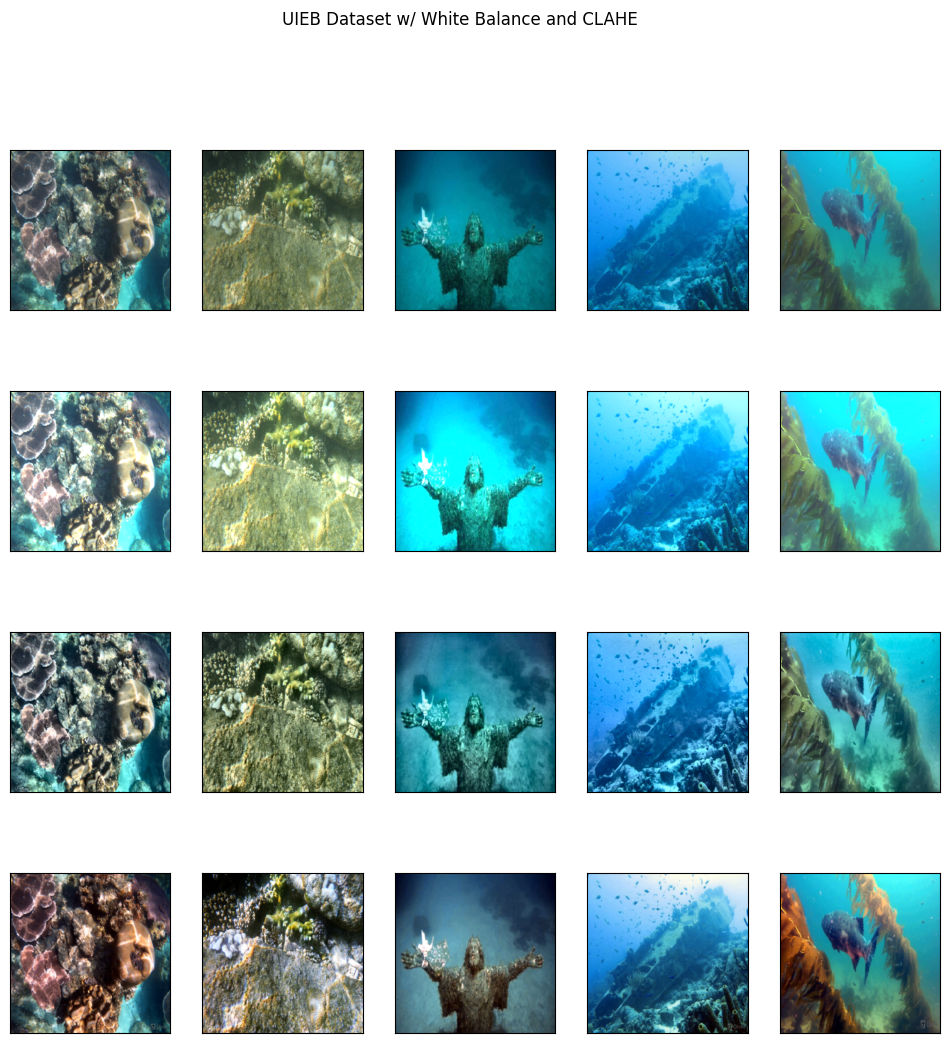

In [8]:
fig, axes = plt.subplots(4, num_images)
fig.set_figwidth(12)
fig.set_figheight(12)
plt.suptitle('UIEB Dataset w/ White Balance and CLAHE')

for idx in range(num_images):
    img, ref = viz_dataset[idx]
    wb, eq = white_balance(img), clahe(img)


    # UNCOMMENT ONCE ALL IMAGES ARE WORKING
    axes[0][idx].imshow(np.transpose(img.numpy(), (1,2,0)))
    axes[1][idx].imshow(np.transpose(wb.numpy(), (1,2,0)))
    axes[2][idx].imshow(np.transpose(eq.numpy(), (1,2,0)))
    axes[3][idx].imshow(np.transpose(ref.numpy(), (1,2,0)))
#     axes[0][idx].imshow(img)
#     axes[1][idx].imshow(wb)
#     axes[2][idx].imshow(eq)
#     axes[3][idx].imshow(ref)
    axes[0][idx].set_xticks([])
    axes[0][idx].set_yticks([])
    axes[1][idx].set_xticks([])
    axes[1][idx].set_yticks([])
    axes[2][idx].set_xticks([])
    axes[2][idx].set_yticks([])
    axes[3][idx].set_xticks([])
    axes[3][idx].set_yticks([])

In [9]:
class Placeholder(nn.Module):
    def __init__(self, in_channels = 3):
        super(Placeholder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)
        self.conv2 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)
        self.conv3 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        return x

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, n=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = n, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = n, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x1 = x
        out = F.gelu(self.conv1(x))
        out = F.gelu(self.conv2(out))
        out = F.gelu(self.conv3(out))
        out = self.conv4(out)

        # pixel-wise addition
        out += x1
        return out

class REM(nn.Module):
    def __init__(self, n=3):
        super(REM, self).__init__()

        self.residual_block1 = ResidualBlock(n=n)
        self.residual_block2 = ResidualBlock(n=n)

    def forward(self, x):
        x = self.residual_block1(x)
        x = self.residual_block2(x)

        return x


In [13]:
class MFFModule(nn.Module):
    def __init__(self, groups):
        super(MFFModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.conv3x3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=5, stride=1, padding='same')
#         self.channel_shuffle = nn.ChannelShuffle(groups)
        self.final_conv3x3 = nn.Conv2d(in_channels = 3*3, out_channels = 3, kernel_size=3, stride=1, padding=1)

    def forward(self, fb1, fb2, fb3):
        f1 = F.gelu(self.conv1x1(fb1))
        f2 = F.gelu(self.conv3x3(fb2))
        f3 = F.gelu(self.conv5x5(fb3))

        # Pixel-wise addition
        f1 = f1 + fb1
        f2 = f2 + fb2
        f3 = f3 + fb3

        # Concatenate the feature maps
        f_cat = torch.cat((f1, f2, f3), dim=1)

        # Channel Shuffle
        f_shuffle = f_cat # self.channel_shuffle(f_cat)

        # Final convolution
        out = self.final_conv3x3(f_shuffle)
        return out

In [14]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride=1, padding='same')

    def forward(self, x):
        b = self.conv1(x)
        m = F.max_pool2d(b, kernel_size=2, stride=2, padding=1)
        m = self.conv1(m)
        s = F.max_pool2d(m, kernel_size=2, stride=2, padding=1)
        s = self.conv1(s)

        return b, m, s

In [15]:
class PCAM(nn.Module):
    def __init__(self, n_size=3):
        super(PCAM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=3, stride=1, padding='same')
        self.conv2_33 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=3, stride=1, padding='same')
        self.conv2_11 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=1, stride=1, padding='same')
        self.fc1 = nn.Linear(in_features=n_size, out_features=n_size)
        self.fc2 = nn.Linear(in_features=n_size, out_features=n_size)

    def forward(self, x):
        x1 = F.gelu(self.conv1(x))

        x2_33 = self.conv2_33(x1)
        x2_11 = F.sigmoid(self.conv2_11(x1))
        x2 = x2_33 * x2_11

        x3 = torch.mean(x2.flatten(start_dim=2), dim=-1)
        x3 = F.gelu(self.fc1(x3))
        x3 = F.sigmoid(self.fc2(x3))
        x3 = x3.reshape(*x3.shape, 1, 1)

        out = x + x2 + (x3 * x1)

        return out


In [16]:
class MFEF(nn.Module):
    def __init__(self, channel_shuffle_groups=3):
        super(MFEF, self).__init__()
        self.rem1 = REM(n=3)
        self.rem2 = REM(n=3)
        self.rem3 = REM(n=3)
        self.mff1 = MFFModule(channel_shuffle_groups)
        self.mff2 = MFFModule(channel_shuffle_groups)
        self.mff3 = MFFModule(channel_shuffle_groups)

        self.rem4 = REM(n=9)
        self.rem5 = REM(n=6)
        self.rem6 = REM(n=3)
        self.rem4_conv = nn.Conv2d(in_channels = 9, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.rem5_conv = nn.Conv2d(in_channels = 6, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.rem6_conv = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=1, stride=1, padding='same')

        self.red_conv = Conv()
        self.yellow_conv = Conv()
        self.green_conv = Conv()

        self.pcam1 = PCAM(n_size=9)
        self.pcam2 = PCAM(n_size=9)
        self.pcam3 = PCAM(n_size=9)

        self.rem7 = REM(n=27)
        self.rem8 = REM(n=18)
        self.rem9 = REM(n=9)

        self.out_conv = nn.Conv2d(in_channels = 27, out_channels = 3, kernel_size=3, stride=1, padding='same')

    def forward(self, image, wb, clahe):
        # Residual Block One
        rem1_out = self.rem1(image)
        rem2_out = self.rem2(wb)
        rem3_out = self.rem3(clahe)

        # MFF Block
        mff1_out  = self.mff1(rem1_out, rem2_out, rem3_out)
        mff2_out  = self.mff2(rem1_out, rem2_out, rem3_out)
        mff3_out  = self.mff3(rem1_out, rem2_out, rem3_out)

        # Residual Block Two
        rem6_out = self.rem6(mff3_out)
        rem5_out = self.rem5(torch.concat([mff2_out, rem6_out], axis=1))
        rem4_out = self.rem4(torch.concat([mff1_out, rem5_out], axis=1))

        rem4_out = self.rem4_conv(rem4_out)
        rem5_out = self.rem5_conv(rem5_out)
        rem6_out = self.rem6_conv(rem6_out)

        red_in = rem4_out + image
        yellow_in = rem5_out + wb
        green_in = rem6_out + clahe

        Rb, Rm, Rs = self.red_conv(red_in)
        Yb, Ym, Ys = self.yellow_conv(yellow_in)
        Gb, Gm, Gs = self.green_conv(green_in)

        b_cat = torch.cat((Rb, Yb, Gb), dim=1)
        m_cat = torch.cat((Rm, Ym, Gm), dim=1)
        s_cat = torch.cat((Rs, Ys, Gs), dim=1)

        pcam1_out = self.pcam1(b_cat)
        pcam2_out = self.pcam2(m_cat)
        pcam3_out = self.pcam3(s_cat)

        rem9_out = self.rem9(pcam3_out)
        rem9_out_scaled = F.interpolate(rem9_out, scale_factor=2)
        # This is dumb, find better way to do this
        if rem9_out_scaled.shape[2] != pcam2_out.shape[2]:
            rem9_out_scaled = rem9_out_scaled[:, :, :pcam2_out.shape[2]]
        if rem9_out_scaled.shape[3] != pcam2_out.shape[3]:
            rem9_out_scaled = rem9_out_scaled[:, :, :, :pcam2_out.shape[3]]
        rem8_out = self.rem8(torch.concat([pcam2_out, rem9_out_scaled], axis=1))
        rem8_out_scaled = F.interpolate(rem8_out, scale_factor=2)
        # This is dumb, find better way to do this
        if rem8_out_scaled.shape[2] != pcam1_out.shape[2]:
            rem8_out_scaled = rem8_out_scaled[:, :, :pcam1_out.shape[2]]
        if rem8_out_scaled.shape[3] != pcam1_out.shape[3]:
            rem8_out_scaled = rem8_out_scaled[:, :, :, :pcam1_out.shape[3]]
        rem7_out = self.rem7(torch.concat([pcam1_out, rem8_out_scaled], axis=1))
        out = self.out_conv(rem7_out)

        return out

In [21]:
model = MFEF()
model.load_state_dict(torch.load("/kaggle/input/best-weights/best_089_79936.pth"))

<All keys matched successfully>

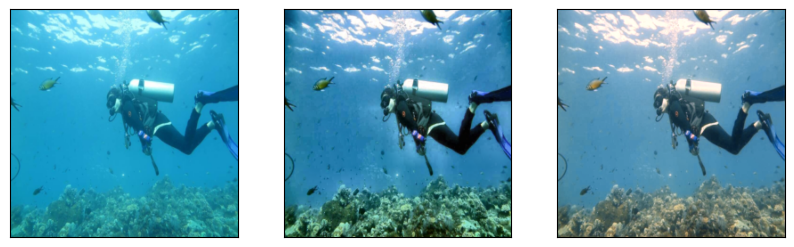

In [36]:
num_images = 30
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.set_figheight(3)
# plt.suptitle('UIEB Dataset w/ White Balance and CLAHE')

save_path = "/kaggle/working"
for idx in range(num_images):
    img, ref = viz_dataset[idx]
    wb, eq = white_balance(img).unsqueeze(dim=0), clahe(img).unsqueeze(dim=0)
    img, ref = img.unsqueeze(dim=0), ref.unsqueeze(dim=0)

    out = model(img, wb, eq)
    

    # UNCOMMENT ONCE ALL IMAGES ARE WORKING
    axes[0].imshow(np.transpose(img.squeeze(dim=0).numpy(), (1,2,0)))
    axes[1].imshow(np.transpose(ref.squeeze(dim=0).numpy(), (1,2,0)))
    axes[2].imshow(np.transpose(out.squeeze(dim=0).detach().numpy(), (1,2,0)))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    filename = os.path.join(save_path, str(idx) + "_viz.png")
    fig.savefig(filename)

In [ ]:
LAYERS = [64, 64, "M", \
          128, 128, "M", \
          256, 256, 256, "M", \
          512, 512, 512, "M", \
          512, 512, 512, "M"]

layer2layer = {
    "conv1.weight" : "features.0.weight", "conv1.bias": "features.0.bias",
    "conv2.weight" : "features.2.weight", "conv2.bias": "features.2.bias",
    "conv3.weight" : "features.5.weight", "conv3.bias": "features.5.bias",
    "conv4.weight" : "features.7.weight", "conv4.bias": "features.7.bias",
    "conv5.weight" : "features.10.weight", "conv5.bias": "features.10.bias",
    "conv6.weight" : "features.12.weight", "conv6.bias": "features.12.bias",
    "conv7.weight" : "features.14.weight", "conv7.bias": "features.14.bias",
    "conv8.weight" : "features.17.weight", "conv8.bias": "features.17.bias",
    "conv9.weight" : "features.19.weight", "conv9.bias": "features.19.bias",
    "conv10.weight" : "features.21.weight", "conv10.bias": "features.21.bias",
    "conv11.weight" : "features.24.weight", "conv11.bias": "features.24.bias",
    "conv12.weight" : "features.26.weight", "conv12.bias": "features.26.bias",
    "conv13.weight" : "features.28.weight", "conv13.bias": "features.28.bias",

}
layer2layer = {value: key for key, value in layer2layer.items()}

class VGG(nn.Module):
    def __init__(self, in_channels = 3) -> None:
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.bn64 = nn.BatchNorm2d(64)
        # self.bn128 = nn.BatchNorm2d(128)
        # self.bn256 = nn.BatchNorm2d(256)
        # self.bn512 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    def ConvBNReLU(self, conv, bn, x):
        x = conv(x)
        x = bn(x)
        x = self.relu(x)
        return x

    def ConvReLU(self, conv, x):
        x = conv(x)
        x = self.relu(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = []
        # Phase One
        x = self.ConvReLU(self.conv1, x)
        out.append(x)
        x = self.ConvReLU(self.conv2, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Two
        x = self.ConvReLU(self.conv3, x)
        out.append(x)
        x = self.ConvReLU(self.conv4, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Three
        x = self.ConvReLU(self.conv5, x)
        out.append(x)
        x = self.ConvReLU(self.conv6, x)
        out.append(x)
        x = self.ConvReLU(self.conv7, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Four
        x = self.ConvReLU(self.conv8, x)
        out.append(x)
        x = self.ConvReLU(self.conv9, x)
        out.append(x)
        x = self.ConvReLU(self.conv10, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Five
        x = self.ConvReLU(self.conv11, x)
        out.append(x)
        x = self.ConvReLU(self.conv12, x)
        out.append(x)
        x = self.ConvReLU(self.conv13, x)
        out.append(x)
        x = self.maxpool(x)

        return out

vgg = VGG()
vgg_weights = torch.load("/kaggle/input/vgg16-397923af-pth/vgg16-397923af.pth")
vgg_weights = OrderedDict({layer2layer[k]: v for k, v in vgg_weights.items() if k in layer2layer.keys()})
vgg.load_state_dict(vgg_weights)

In [ ]:
class LossFunc(nn.Module):
    def forward(self, pred, target, model):
        target_out = model(target)
        pred_out = model(pred)
        model_loss = 0
        for target_layer, pred_layer in zip(target_out, pred_out):
            model_loss += torch.sum(torch.abs(target_layer - pred_layer))
        l1_loss = torch.mean(torch.abs(target - pred))
        return l1_loss + 0.05*model_loss

In [ ]:
!nvidia-smi

In [ ]:
EPOCHS = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = LossFunc()
print_every = 150
test_losses, train_losses = [], []
train_loader, test_loader = build_dataset()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)
vgg.to(device)

In [ ]:
print("Model loaded on", next(model.parameters()).device)
print("VGG loaded on", next(vgg.parameters()).device)

In [ ]:
def prep_wb_eq(image):
    wb, eq = white_balance(image.cpu()[0]), clahe(image.cpu()[0])
    wb, eq = wb.unsqueeze(dim=0), eq.unsqueeze(dim=0)
    wb, eq = wb.to(device), eq.to(device)
    
    return wb, eq

In [ ]:
best_loss = 99999999.0
for e in range(EPOCHS):
    running_loss = 0
    step = 0
    for image, label in train_loader:
        wb, eq = prep_wb_eq(image)
        image, label = image.to(device), label.to(device)
        step += 1
        optimizer.zero_grad()
        out = model(image, wb, eq)
        loss = loss_func(out, label, vgg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                # model -> eval means gradients aren't calculated + no backprop
                model.eval()
                for image, label in test_loader:
                    wb, eq = prep_wb_eq(image)
                    image, label = image.to(device), label.to(device)
                    out = model(image, wb, eq)
                    loss = loss_func(out, label, vgg)
                    test_loss += loss.item()
                # model -> train means gradients are calculated + backprop
                model.train()
                
                train_losses.append(running_loss/print_every)
                test_losses.append(test_loss/len(test_loader))

                if test_losses[-1] < best_loss:
                    if not os.path.isdir("/kaggle/working/weights"):
                        os.mkdir("/kaggle/working/weights")
                    filename = f"best_{e:03d}_{int(test_losses[-1])}.pth"
                    torch.save(model.state_dict(), os.path.join("/kaggle/working/weights", filename))
                
                print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
                      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                      "Test Loss: {:.3f}.. ".format(test_losses[-1]))

                running_loss = 0

print("Done Training...")

In [2]:
files = []
for file in os.listdir("/kaggle/working/weights"):
    files.append(file)

files.sort()
print(files)

# for file in os.listdir("/kaggle/working/weights"):
#     print("Removing", file)
#     os.remove(os.path.join("/kaggle/working/weights", file))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/weights'

In [ ]:
import scipy.signal

# source: https://github.com/deepxzy/PCQI-python/blob/master/pcqi.py
def PCQI(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    mu1 = scipy.signal.correlate2d(img1, window, 'valid')
    mu2 = scipy.signal.correlate2d(img2, window, 'valid')
    mu1_sq = mu1 * mu1

    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2


    sigma1_sq = scipy.signal.correlate2d(img1 * img1, window, 'valid')- mu1_sq
    sigma2_sq = scipy.signal.correlate2d(img2 * img2, window, 'valid') - mu2_sq
    sigma12 = scipy.signal.correlate2d(img1 * img2, window, 'valid') - mu1_mu2

    sigma1_sq[sigma1_sq<0]=0
    sigma2_sq[sigma2_sq<0]=0


    C = 3

    pcqi_map = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
    pcqi_map = pcqi_map * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
    pcqi_map = pcqi_map * np.exp(-abs(mu1 - mu2) / L)

    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map

def PCQI_3d(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    pcqi_map_channels = []

    # Iterate over each channel
    for channel in range(3):
        img1_channel = img1[:,:,channel]
        img2_channel = img2[:,:,channel]

        mu1 = scipy.signal.correlate2d(img1_channel, window, 'valid')
        mu2 = scipy.signal.correlate2d(img2_channel, window, 'valid')

        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = scipy.signal.correlate2d(img1_channel * img1_channel, window, 'valid') - mu1_sq
        sigma2_sq = scipy.signal.correlate2d(img2_channel * img2_channel, window, 'valid') - mu2_sq
        sigma12 = scipy.signal.correlate2d(img1_channel * img2_channel, window, 'valid') - mu1_mu2

        sigma1_sq[sigma1_sq < 0] = 0
        sigma2_sq[sigma2_sq < 0] = 0

        C = 3

        pcqi_map_channel = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
        pcqi_map_channel = pcqi_map_channel * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
        pcqi_map_channel = pcqi_map_channel * np.exp(-abs(mu1 - mu2) / L)

        pcqi_map_channels.append(pcqi_map_channel)

    # Average PCQI across channels
    pcqi_map = np.mean(pcqi_map_channels, axis=0)
    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map

In [ ]:
import scipy.signal

# source: https://github.com/deepxzy/PCQI-python/blob/master/pcqi.py
def PCQI(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    mu1 = scipy.signal.correlate2d(img1, window, 'valid')
    mu2 = scipy.signal.correlate2d(img2, window, 'valid')
    mu1_sq = mu1 * mu1

    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2


    sigma1_sq = scipy.signal.correlate2d(img1 * img1, window, 'valid')- mu1_sq
    sigma2_sq = scipy.signal.correlate2d(img2 * img2, window, 'valid') - mu2_sq
    sigma12 = scipy.signal.correlate2d(img1 * img2, window, 'valid') - mu1_mu2

    sigma1_sq[sigma1_sq<0]=0
    sigma2_sq[sigma2_sq<0]=0


    C = 3

    pcqi_map = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
    pcqi_map = pcqi_map * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
    pcqi_map = pcqi_map * np.exp(-abs(mu1 - mu2) / L)

    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map

def PCQI_3d(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    pcqi_map_channels = []

    # Iterate over each channel
    for channel in range(3):
        img1_channel = img1[:,:,channel]
        img2_channel = img2[:,:,channel]

        mu1 = scipy.signal.correlate2d(img1_channel, window, 'valid')
        mu2 = scipy.signal.correlate2d(img2_channel, window, 'valid')

        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = scipy.signal.correlate2d(img1_channel * img1_channel, window, 'valid') - mu1_sq
        sigma2_sq = scipy.signal.correlate2d(img2_channel * img2_channel, window, 'valid') - mu2_sq
        sigma12 = scipy.signal.correlate2d(img1_channel * img2_channel, window, 'valid') - mu1_mu2

        sigma1_sq[sigma1_sq < 0] = 0
        sigma2_sq[sigma2_sq < 0] = 0

        C = 3

        pcqi_map_channel = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
        pcqi_map_channel = pcqi_map_channel * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
        pcqi_map_channel = pcqi_map_channel * np.exp(-abs(mu1 - mu2) / L)

        pcqi_map_channels.append(pcqi_map_channel)

    # Average PCQI across channels
    pcqi_map = np.mean(pcqi_map_channels, axis=0)
    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import Callback

class LossPlotter(Callback):
    def on_train_begin(self, logs={}):
        self.train_loss = []
        self.val_loss = []

    def on_epoch_end(self, epoch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.plot_loss()

    def plot_loss(self):
        epochs = range(1, len(self.train_loss) + 1)
        plt.figure()
        plt.plot(epochs, self.train_loss, 'bo', label='Training loss')
        plt.plot(epochs, self.val_loss, 'r', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()